In [ ]:
import os
import logging
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.graphics.gofplots import qqplot

from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import classification_report, precision_recall_curve, auc, accuracy_score
from sklearn.ensemble import IsolationForest
from xgboost import XGBClassifier as xgb

from imblearn.over_sampling import SMOTE

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

In [22]:
RANDOM_STATE = 42
CONTAMINATION = 0.0017

logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

In [ ]:
def load(csv_path):
    df = pd.read_csv(csv_path)
    print("Dataset shape:", df.shape)
    print(df['Class'].value_counts())
    print("\nDistribution:")
    print(df['Class'].value_counts(normalize=True) * 100)
    return df

df = load('creditcard.csv')
print(df['Amount'])

def engineer(df):
    ## standardize Amount then log-transform
    df['Amount'] = (df['Amount'] - df['Amount'].mean()) / df['Amount'].std()
    df['LogAmount'] = np.log1p(df['Amount'])
    ## time to cyclical
    df['Hour'] = (df['Time'] / 3600) % 24
    df['Hour_sin'] = np.sin(2 * np.pi * df['Hour'] / 24)
    df['Hour_cos'] = np.cos(2 * np.pi * df['Hour'] / 24)

    df.drop(['Time','Hour','Amount'], axis=1, inplace=True)
    return df

Dataset shape: (284807, 31)
Class
0    284315
1       492
Name: count, dtype: int64

Distribution:
Class
0    99.827251
1     0.172749
Name: proportion, dtype: float64
0         149.62
1           2.69
2         378.66
3         123.50
4          69.99
           ...  
284802      0.77
284803     24.79
284804     67.88
284805     10.00
284806    217.00
Name: Amount, Length: 284807, dtype: float64


In [ ]:
df = load('creditcard.csv')
def exploratory_analysis(df):
    # transaction Amount distribution
    plt.figure(figsize=(6,4))
    sns.histplot(df['Amount'], bins=50, kde=True)
    plt.title('Transaction Amount Distribution')
    plt.show()

    # log-amount to reduce skew
    df['LogAmount'] = np.log1p(df['Amount'])
    plt.figure(figsize=(6,4))
    sns.histplot(df['LogAmount'], bins=50, kde=True)
    plt.title('Log-transformed Amount Distribution')
    plt.show()

    # time feature over classes
    plt.figure(figsize=(6,4))
    sns.kdeplot(df[df['Class']==0]['Time'], label='Legit', bw_adjust=0.5)
    sns.kdeplot(df[df['Class']==1]['Time'], label='Fraud', bw_adjust=0.5)
    plt.title('Transaction Time Density by Class')
    plt.legend()
    plt.show()

    # correlation heatmap (top 11)
    feats = ['V14', 'V17', 'V10', 'V18', 'V9', 'V11', 'V5', 'V4', 'V8', 'V1', 'V27']
    plt.figure(figsize=(10,8))
    corr = df.loc[feats].corr()
    sns.heatmap(corr, cmap='coolwarm', annot=False)
    plt.title('Correlation of V1-V10')
    plt.show()


def Box_plots(df):
    plt.figure(figsize=(10, 4))
    plt.title("Box Plot")
    sns.boxplot(df)
    plt.show()
Box_plots(df['Time'])

def hist_plots(df):
    plt.figure(figsize=(10, 4))
    plt.hist(df)
    plt.title("Histogram Plot")
    plt.show()
hist_plots(df['Amount'])
hist_plots(df['Time'])

def dist_plots(df):
    plt.figure(figsize=(10, 4))
    sns.distplot(df)
    plt.title("Distribution plot")
    sns.despine()
    plt.show()
dist_plots(df['Amount'])
dist_plots(df['Time'])

def qq_plots(df):
    plt.figure(figsize=(10, 4))
    qqplot(df,line='s')
    plt.title("Normal QQPlot")
    plt.show()
qq_plots(df['Time'])
qq_plots(df['Amount'])

# exploratory_analysis(df)

In [ ]:
## Features Density plot
var = df.columns.values

i = 0
t0 = df.loc[df['Class'] == 0]
t1 = df.loc[df['Class'] == 1]

sns.set_style('whitegrid')
plt.figure()
fig, ax = plt.subplots(8,4,figsize=(16,28))

for feature in var:
    i += 1
    plt.subplot(8,4,i)
    sns.kdeplot(t0[feature], bw=0.5,label="Class = 0")
    sns.kdeplot(t1[feature], bw=0.5,label="Class = 1")
    plt.xlabel(feature, fontsize=12)
    locs, labels = plt.xticks()
    plt.tick_params(axis='both', which='major', labelsize=12)
plt.show()

In [ ]:
def select_top_features(df, top_n=20):
    X = df.drop('Class', axis=1)
    y = df['Class']
    xgb_clf = xgb.XGBClassifier(
        objective='binary:logistic', # threshold of 0.5
        use_label_encoder=False,
        eval_metric='aucpr',
        random_state=RANDOM_STATE,
        n_jobs=-1
    )
    xgb_clf.fit(X, y)
    feat_imp = pd.Series(xgb_clf.feature_importances_, index=X.columns)
    top_feats = feat_imp.nlargest(top_n).index.tolist()
    logger.info(f"Selected top {top_n} features: {top_feats}")
    return top_feats

In [ ]:
class Autoencoder(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 16), nn.ReLU(),
            nn.Linear(16, 8), nn.ReLU()
        )
        self.decoder = nn.Sequential(
            nn.Linear(8, 16), nn.ReLU(),
            nn.Linear(16, input_dim)
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

def compute_anomaly_scores(df, method='iforest', contamination=0.0017):
    features = df.drop('Class', axis=1)
    if method == 'iforest':
        model = IsolationForest(contamination=contamination, random_state=42)
        model.fit(features)
        scores = model.decision_function(features)
        df['AnomalyScore'] = -scores
    elif method == 'autoencoder':
        scaler = MinMaxScaler()
        scaled_features = scaler.fit_transform(features)
        X_tensor = torch.tensor(scaled_features, dtype=torch.float32)
        input_dim = X_tensor.shape[1]
        model = Autoencoder(input_dim)
        criterion = nn.MSELoss()
        optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
        
        model.train()
        for _ in range(20):
            optimizer.zero_grad()
            output = model(X_tensor) # forward pass
            loss = criterion(output, X_tensor) # compute loss
            loss.backward() # backpropagation
            optimizer.step() # update weights
            
        model.eval()
        with torch.no_grad():
            recon = model(X_tensor)
            errors = torch.mean((X_tensor - recon)**2, dim=1).numpy()
        df['AnomalyScore'] = errors
    else:
        raise ValueError("Unsupported anomaly detection method")
    return df


In [ ]:
def get_dataloaders(df, test_size=0.1, val_size=0.1, batch_size=2048, random_state=42):
    X = df.drop('Class', axis=1).values
    y = df['Class'].values

    X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=test_size, stratify=y, random_state=random_state)

    rel_val = val_size / (1 - test_size)
    X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=rel_val, stratify=y_temp, random_state=random_state)

    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_val = scaler.transform(X_val)
    X_test = scaler.transform(X_test)

    sm = SMOTE(random_state=random_state)
    X_train, y_train = sm.fit_resample(X_train, y_train)

    def to_loader(X_arr, y_arr=None, shuffle=False):
        X_t = torch.tensor(X_arr, dtype=torch.float32)
        if y_arr is None:
            return DataLoader(X_t, batch_size=batch_size)
        y_t = torch.tensor(y_arr, dtype=torch.float32).unsqueeze(1)
        ds = TensorDataset(X_t, y_t)
        return DataLoader(ds, batch_size=batch_size, shuffle=shuffle)

    return (to_loader(X_train, y_train, True), to_loader(X_val, y_val), to_loader(X_test, y_test), scaler)

In [30]:
class FraudModel(nn.Module):
    def __init__(self, input_dim, activation='relu'):
        super().__init__()
        act = nn.ReLU() if activation == 'relu' else nn.Tanh()
        
        self.net = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.BatchNorm1d(64),
            act,
            nn.Dropout(0.5),
            
            nn.Linear(64, 32),
            nn.BatchNorm1d(32),
            act,
            nn.Dropout(0.5),
            
            nn.Linear(32, 1),
            nn.Sigmoid()
        )
        
    def forward(self, x):
        return self.net(x)

In [ ]:
def train_eval(train_loader, val_loader, test_loader, input_dim, activation, optimizer_name, epochs=20, device=None):
    device = device or ('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")
    if device == 'cuda':
        torch.cuda.empty_cache()

    model = FraudModel(input_dim, activation=activation).to(device)
    optimizer = getattr(optim, optimizer_name)(model.parameters(), lr=1e-3, weight_decay=1e-4)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=5)
    criterion = nn.BCELoss()
    
    best_auc = 0.0
    wait = 0
    patience = 10
    best_test_acc = 0.0

    history = {'train_loss':[], 'val_loss':[], 'train_acc':[], 'val_acc':[]}

    for epoch in range(epochs):
        model.train()
        train_loss=0
        for xb, yb in train_loader:
            xb, yb = xb.to(device), yb.to(device)
            optimizer.zero_grad()
            preds = model(xb)
            loss = criterion(preds, yb)
            loss.backward(); optimizer.step()
            train_loss += loss.item()*xb.size(0)
        history['train_loss'].append(train_loss/len(train_loader.dataset))

        ## train acc
        y_t, y_p = [], []
        model.eval()
        with torch.no_grad():
            for xb, yb in train_loader:
                xb = xb.to(device)
                out = model(xb).cpu().numpy().flatten()
                y_t.extend(yb.numpy()); y_p.extend((out>0.5).astype(int))
        history['train_acc'].append(accuracy_score(y_t, y_p))

        ## val
        val_loss=0; y_vt, y_vp = [], []
        with torch.no_grad():
            for xb, yb in val_loader:
                xb, yb = xb.to(device), yb.to(device)
                out = model(xb)
                loss = criterion(out, yb)
                val_loss += loss.item()*xb.size(0)
                y_vt.extend(yb.cpu().numpy()); y_vp.extend((out.cpu().numpy().flatten()>0.5).astype(int))
        history['val_loss'].append(val_loss/len(val_loader.dataset))
        history['val_acc'].append(accuracy_score(y_vt, y_vp))

        # aupruc
        precision, recall, _ = precision_recall_curve(y_vt, y_vp)
        val_auc = auc(recall, precision)
        scheduler.step(val_loss)
        print(f"Epoch {epoch+1}/{epochs} - TL={history['train_loss'][-1]:.4f}, VL={history['val_loss'][-1]:.4f}, TA={history['train_acc'][-1]:.4f}, VA={history['val_acc'][-1]:.4f}, VAUPRC={val_auc:.4f}")

        # earlyy stopping
        if val_auc > best_auc:
            best_auc = val_auc
            wait = 0
            torch.save(model.state_dict(), 'best_model.pt')
        else:
            wait += 1
            if wait >= patience:
                print("Early stopping")
                break

    ### load best based on validation AUPRC
    model.load_state_dict(torch.load('best_model.pt'))

    ### test evaluation
    y_tt, y_tp = [], []
    with torch.no_grad():
        for xb, yb in test_loader:
            xb = xb.to(device)
            out = model(xb).cpu().numpy().flatten()
            y_tt.extend(yb.numpy().flatten()); y_tp.extend((out>0.5).astype(int))
    precision, recall, _ = precision_recall_curve(y_tt, y_tp)
    test_auc = auc(recall, precision)
    test_acc = accuracy_score(y_tt, y_tp)
    print("Test AUPRC:", test_auc)
    print(f"Test Accuracy: {test_acc:.4f}")
    print(classification_report(y_tt, y_tp))

    ### save best test accuracy model
    if test_acc > best_test_acc:
        best_test_acc = test_acc
        name = f'best_test_model_{optimizer_name}_{activation}_acc_{test_acc:.4f}.pt'
        torch.save(model.state_dict(), name)
        print(f"Saved {name} with accuracy {test_acc:.4f}")

    ### train and val loss
    ep_range = range(1, len(history['train_loss'])+1)
    plt.figure(figsize=(12,5))
    plt.subplot(1,2,1)
    plt.plot(ep_range, history['train_loss'], label='Train Loss')
    plt.plot(ep_range, history['val_loss'],   label='Val Loss')
    plt.title('Loss'); plt.legend(); plt.grid(True)

    ### train and val loss
    plt.subplot(1,2,2)
    plt.plot(ep_range, history['train_acc'], label='Train Acc')
    plt.plot(ep_range, history['val_acc'],   label='Val Acc')
    plt.title('Accuracy'); plt.legend(); plt.grid(True)
    plt.tight_layout(); plt.show()

    return model, history


Dataset shape: (284807, 31)
Class
0    284315
1       492
Name: count, dtype: int64

Distribution:
Class
0    99.827251
1     0.172749
Name: proportion, dtype: float64
Training with relu activation and SGD optimizer
Using device: cuda
Epoch 1/50 - TL=0.6951, VL=0.6412, TA=0.8513, VA=0.8520, VAUPRC=0.4439
Epoch 2/50 - TL=0.6080, VL=0.5797, TA=0.9022, VA=0.9790, VAUPRC=0.4402
Epoch 3/50 - TL=0.5564, VL=0.5273, TA=0.9026, VA=0.9953, VAUPRC=0.5413
Epoch 4/50 - TL=0.5201, VL=0.4828, TA=0.9040, VA=0.9965, VAUPRC=0.5726
Epoch 5/50 - TL=0.4923, VL=0.4470, TA=0.9045, VA=0.9969, VAUPRC=0.5893
Epoch 6/50 - TL=0.4693, VL=0.4107, TA=0.9049, VA=0.9974, VAUPRC=0.6083
Epoch 7/50 - TL=0.4498, VL=0.3863, TA=0.9056, VA=0.9975, VAUPRC=0.6175
Epoch 8/50 - TL=0.4317, VL=0.3603, TA=0.9060, VA=0.9977, VAUPRC=0.6387
Epoch 9/50 - TL=0.4160, VL=0.3363, TA=0.9075, VA=0.9978, VAUPRC=0.6408
Epoch 10/50 - TL=0.4016, VL=0.3151, TA=0.9096, VA=0.9978, VAUPRC=0.6430
Epoch 11/50 - TL=0.3883, VL=0.2935, TA=0.9111, VA=0.99

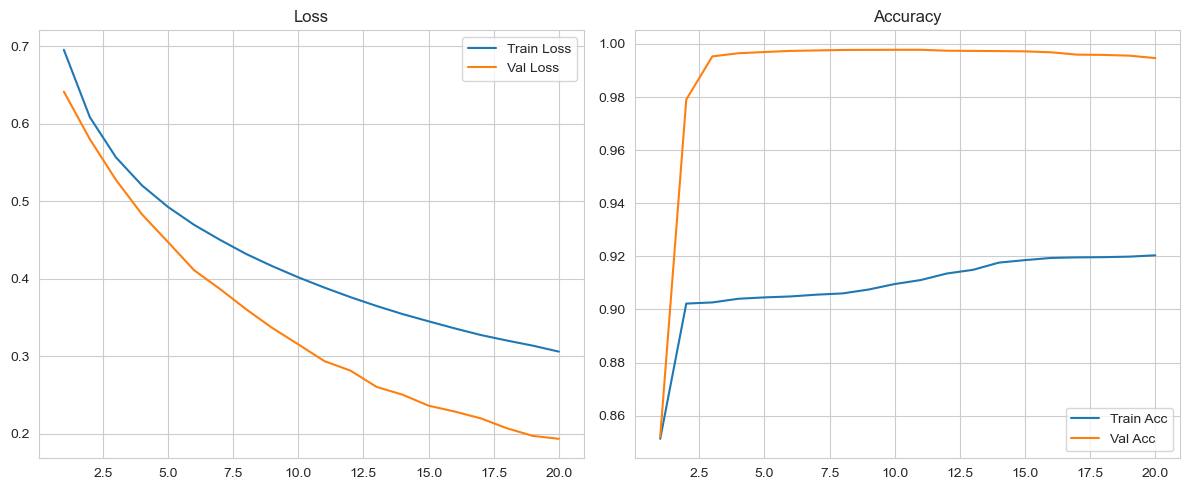

Test Accuracy for relu-SGD: 0.9973
Training with relu activation and Adam optimizer
Using device: cuda
Epoch 1/50 - TL=0.2564, VL=0.0975, TA=0.9509, VA=0.9735, VAUPRC=0.5090
Epoch 2/50 - TL=0.1250, VL=0.0577, TA=0.9733, VA=0.9843, VAUPRC=0.5165
Epoch 3/50 - TL=0.0870, VL=0.0364, TA=0.9863, VA=0.9890, VAUPRC=0.5116
Epoch 4/50 - TL=0.0648, VL=0.0335, TA=0.9919, VA=0.9915, VAUPRC=0.5276
Epoch 5/50 - TL=0.0491, VL=0.0239, TA=0.9954, VA=0.9945, VAUPRC=0.5613
Epoch 6/50 - TL=0.0387, VL=0.0198, TA=0.9970, VA=0.9957, VAUPRC=0.5849
Epoch 7/50 - TL=0.0330, VL=0.0222, TA=0.9970, VA=0.9948, VAUPRC=0.5673
Epoch 8/50 - TL=0.0300, VL=0.0180, TA=0.9980, VA=0.9960, VAUPRC=0.5813
Epoch 9/50 - TL=0.0259, VL=0.0173, TA=0.9988, VA=0.9966, VAUPRC=0.5981
Epoch 10/50 - TL=0.0236, VL=0.0181, TA=0.9986, VA=0.9962, VAUPRC=0.5998
Epoch 11/50 - TL=0.0225, VL=0.0169, TA=0.9990, VA=0.9971, VAUPRC=0.6180
Epoch 12/50 - TL=0.0224, VL=0.0164, TA=0.9991, VA=0.9971, VAUPRC=0.6180
Epoch 13/50 - TL=0.0196, VL=0.0151, TA=0.9

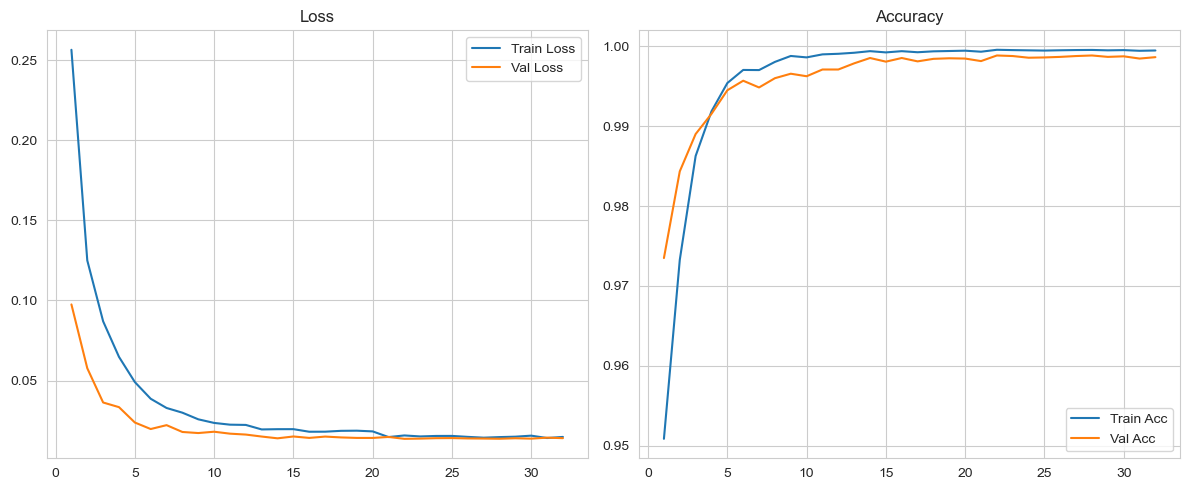

Test Accuracy for relu-Adam: 0.9986
Training with relu activation and RMSprop optimizer
Using device: cuda
Epoch 1/50 - TL=0.1703, VL=0.0621, TA=0.9703, VA=0.9822, VAUPRC=0.5113
Epoch 2/50 - TL=0.0882, VL=0.0368, TA=0.9870, VA=0.9879, VAUPRC=0.5175
Epoch 3/50 - TL=0.0597, VL=0.0308, TA=0.9925, VA=0.9915, VAUPRC=0.5385
Epoch 4/50 - TL=0.0443, VL=0.0207, TA=0.9950, VA=0.9952, VAUPRC=0.5734
Epoch 5/50 - TL=0.0352, VL=0.0212, TA=0.9974, VA=0.9953, VAUPRC=0.5770
Epoch 6/50 - TL=0.0294, VL=0.0193, TA=0.9979, VA=0.9962, VAUPRC=0.5987
Epoch 7/50 - TL=0.0254, VL=0.0161, TA=0.9989, VA=0.9973, VAUPRC=0.6275
Epoch 8/50 - TL=0.0229, VL=0.0156, TA=0.9892, VA=0.9974, VAUPRC=0.6343
Epoch 9/50 - TL=0.0227, VL=0.0158, TA=0.9991, VA=0.9981, VAUPRC=0.6515
Epoch 10/50 - TL=0.0202, VL=0.0199, TA=0.9990, VA=0.9976, VAUPRC=0.6346
Epoch 11/50 - TL=0.0196, VL=0.0160, TA=0.9989, VA=0.9979, VAUPRC=0.6413
Epoch 12/50 - TL=0.0190, VL=0.0155, TA=0.9993, VA=0.9982, VAUPRC=0.6626
Epoch 13/50 - TL=0.0178, VL=0.0158, TA

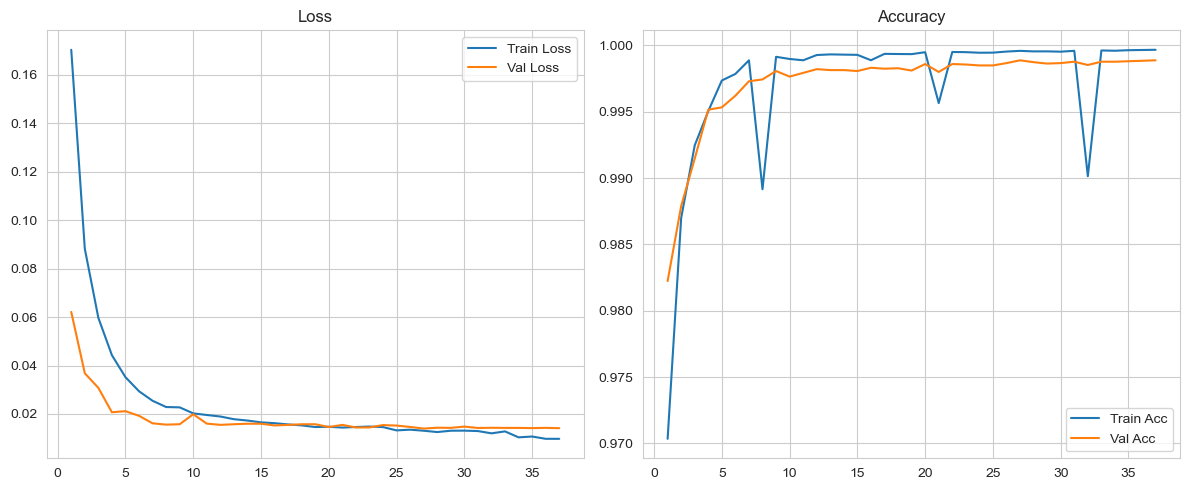

Test Accuracy for relu-RMSprop: 0.9988
Training with tanh activation and SGD optimizer
Using device: cuda
Epoch 1/50 - TL=0.6216, VL=0.4218, TA=0.8863, VA=0.9930, VAUPRC=0.4840
Epoch 2/50 - TL=0.4768, VL=0.3002, TA=0.8972, VA=0.9971, VAUPRC=0.5838
Epoch 3/50 - TL=0.4145, VL=0.2415, TA=0.8997, VA=0.9979, VAUPRC=0.6257
Epoch 4/50 - TL=0.3797, VL=0.2026, TA=0.9009, VA=0.9981, VAUPRC=0.6464
Epoch 5/50 - TL=0.3570, VL=0.1769, TA=0.9040, VA=0.9981, VAUPRC=0.6464
Epoch 6/50 - TL=0.3402, VL=0.1586, TA=0.9047, VA=0.9983, VAUPRC=0.6716
Epoch 7/50 - TL=0.3269, VL=0.1443, TA=0.9051, VA=0.9983, VAUPRC=0.6748
Epoch 8/50 - TL=0.3168, VL=0.1353, TA=0.9057, VA=0.9984, VAUPRC=0.6880
Epoch 9/50 - TL=0.3083, VL=0.1250, TA=0.9063, VA=0.9984, VAUPRC=0.6880
Epoch 10/50 - TL=0.3007, VL=0.1194, TA=0.9070, VA=0.9984, VAUPRC=0.6912
Epoch 11/50 - TL=0.2940, VL=0.1140, TA=0.9122, VA=0.9984, VAUPRC=0.6880
Epoch 12/50 - TL=0.2876, VL=0.1111, TA=0.9166, VA=0.9983, VAUPRC=0.6889
Epoch 13/50 - TL=0.2822, VL=0.1036, TA=

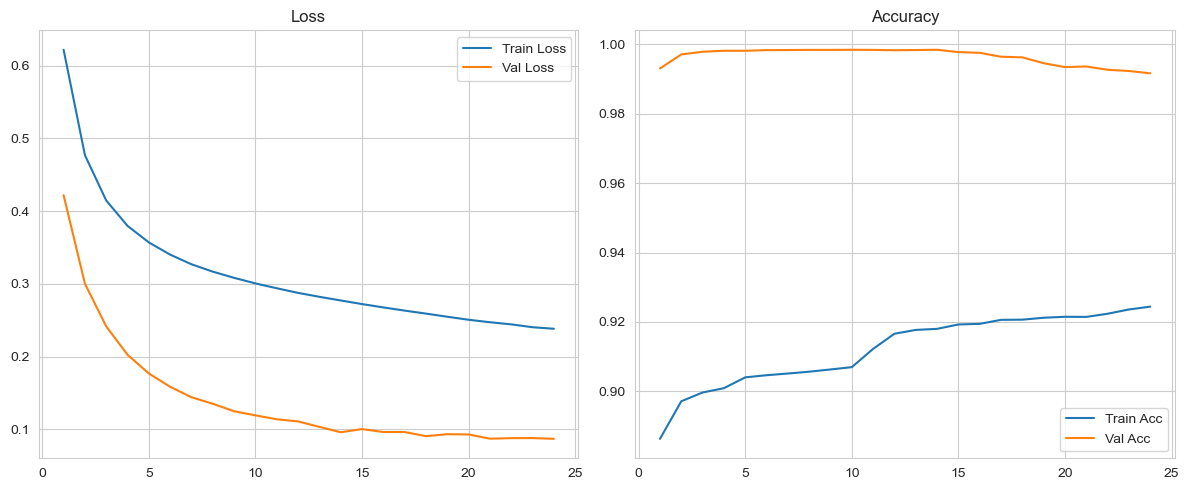

Test Accuracy for tanh-SGD: 0.9982
Training with tanh activation and Adam optimizer
Using device: cuda
Epoch 1/50 - TL=0.2157, VL=0.0999, TA=0.9452, VA=0.9730, VAUPRC=0.5085
Epoch 2/50 - TL=0.1402, VL=0.0910, TA=0.9519, VA=0.9749, VAUPRC=0.5105
Epoch 3/50 - TL=0.1257, VL=0.0810, TA=0.9585, VA=0.9776, VAUPRC=0.5032
Epoch 4/50 - TL=0.1148, VL=0.0709, TA=0.9663, VA=0.9806, VAUPRC=0.5081
Epoch 5/50 - TL=0.1066, VL=0.0607, TA=0.9700, VA=0.9832, VAUPRC=0.5135
Epoch 6/50 - TL=0.0986, VL=0.0581, TA=0.9765, VA=0.9838, VAUPRC=0.5151
Epoch 7/50 - TL=0.0930, VL=0.0560, TA=0.9793, VA=0.9839, VAUPRC=0.5153
Epoch 8/50 - TL=0.0885, VL=0.0500, TA=0.9826, VA=0.9861, VAUPRC=0.5218
Epoch 9/50 - TL=0.0846, VL=0.0523, TA=0.9836, VA=0.9850, VAUPRC=0.5184
Epoch 10/50 - TL=0.0812, VL=0.0475, TA=0.9852, VA=0.9862, VAUPRC=0.5223
Epoch 11/50 - TL=0.0785, VL=0.0420, TA=0.9854, VA=0.9882, VAUPRC=0.5300
Epoch 12/50 - TL=0.0759, VL=0.0419, TA=0.9863, VA=0.9880, VAUPRC=0.5178
Epoch 13/50 - TL=0.0737, VL=0.0447, TA=0.9

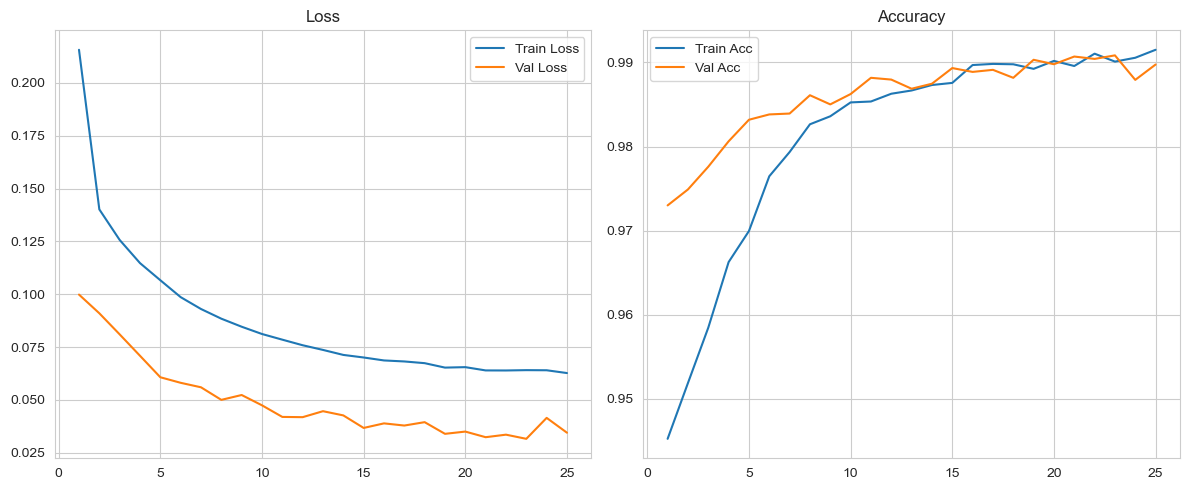

Test Accuracy for tanh-Adam: 0.9904
Training with tanh activation and RMSprop optimizer
Using device: cuda
Epoch 1/50 - TL=0.1655, VL=0.0873, TA=0.9500, VA=0.9765, VAUPRC=0.5126
Epoch 2/50 - TL=0.1278, VL=0.0853, TA=0.9593, VA=0.9752, VAUPRC=0.5109
Epoch 3/50 - TL=0.1152, VL=0.0777, TA=0.9668, VA=0.9770, VAUPRC=0.5132
Epoch 4/50 - TL=0.1059, VL=0.0630, TA=0.9696, VA=0.9827, VAUPRC=0.5124
Epoch 5/50 - TL=0.0973, VL=0.0494, TA=0.9713, VA=0.9871, VAUPRC=0.5144
Epoch 6/50 - TL=0.0917, VL=0.0610, TA=0.9796, VA=0.9821, VAUPRC=0.5111
Epoch 7/50 - TL=0.0861, VL=0.0462, TA=0.9820, VA=0.9874, VAUPRC=0.5265
Epoch 8/50 - TL=0.0815, VL=0.0399, TA=0.9828, VA=0.9889, VAUPRC=0.5333
Epoch 9/50 - TL=0.0777, VL=0.0469, TA=0.9846, VA=0.9869, VAUPRC=0.5249
Epoch 10/50 - TL=0.0749, VL=0.0404, TA=0.9859, VA=0.9887, VAUPRC=0.5212
Epoch 11/50 - TL=0.0725, VL=0.0376, TA=0.9882, VA=0.9889, VAUPRC=0.5225
Epoch 12/50 - TL=0.0707, VL=0.0370, TA=0.9874, VA=0.9889, VAUPRC=0.5221
Epoch 13/50 - TL=0.0687, VL=0.0360, TA

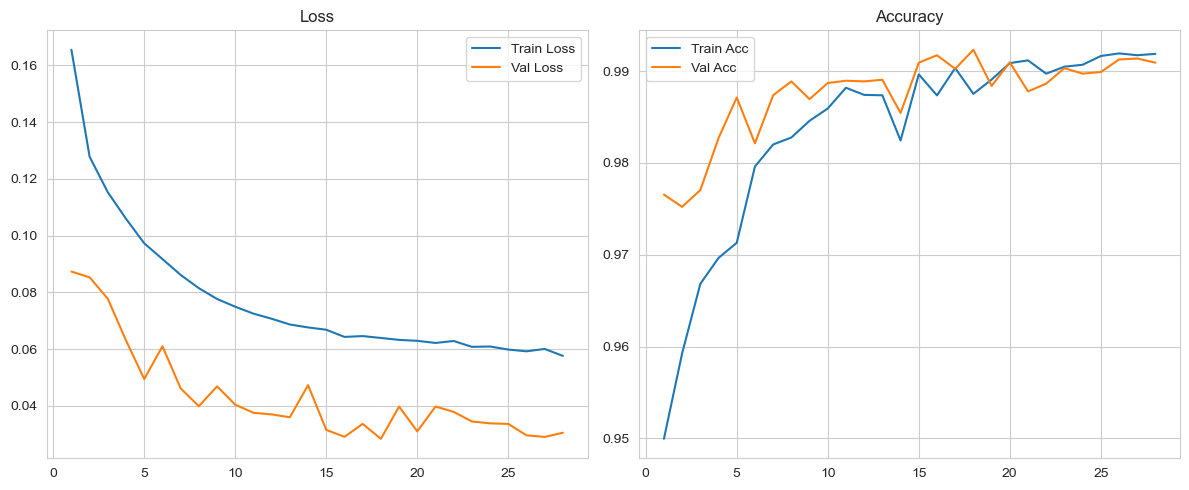

Test Accuracy for tanh-RMSprop: 0.9922
Saved best_fraud_model.pt for ('relu', 'RMSprop') with accuracy 0.9988


In [32]:
if __name__ == '__main__':
    df = load('creditcard.csv')
    df = engineer(df)
    df = compute_anomaly_scores(df, method='autoencoder') #method='iforest')
    train_loader, val_loader, test_loader, scaler = get_dataloaders(df)
    input_dim = next(iter(train_loader))[0].shape[1]

    activations = ['relu', 'tanh']
    optimizers = ['SGD', 'Adam', 'RMSprop']
    best_overall_acc = 0.0
    best_config = None
    best_model_state = None

    for activation in activations:
        for optimizer_name in optimizers:
            print(f"Training with {activation} activation and {optimizer_name} optimizer")
            model, history = train_eval(
                train_loader, val_loader, test_loader,
                input_dim,
                activation=activation,
                optimizer_name=optimizer_name,
                epochs=50,
                device='cuda' if torch.cuda.is_available() else 'cpu'
            )

            y_tt, y_tp = [], []
            model.eval()
            with torch.no_grad():
                for xb, yb in test_loader:
                    xb = xb.to(next(model.parameters()).device)
                    out = model(xb).cpu().numpy().flatten()
                    y_tt.extend(yb.numpy().flatten()); y_tp.extend((out>0.5).astype(int))
            test_acc = accuracy_score(y_tt, y_tp)
            print(f"Test Accuracy for {activation}-{optimizer_name}: {test_acc:.4f}")
            if test_acc > best_overall_acc:
                best_overall_acc = test_acc
                best_config = (activation, optimizer_name)
                best_model_state = model.state_dict()

    if best_model_state is not None:
        torch.save(best_model_state, 'best_fraud_model.pt')
        print(f"Saved best_fraud_model.pt for {best_config} with accuracy {best_overall_acc:.4f}")

    pd.to_pickle(scaler, 'scaler.pkl')


In [ ]:
import pickle
def test_model(model_path, activation, scaler_path='scaler.pkl', batch_size=2048, device=None):
    device = device or ('cuda' if torch.cuda.is_available() else 'cpu')
    
    df = pd.read_csv('creditcard.csv')
    df = engineer(df)
    df = compute_anomaly_scores(df, method='autoencoder')
    
    with open(scaler_path, 'rb') as f:
        scaler = pickle.load(f)
    X = df.drop('Class', axis=1).values
    y = df['Class'].values
    X_scaled = scaler.transform(X)
    
    X_t = torch.tensor(X_scaled, dtype=torch.float32)
    y_t = torch.tensor(y, dtype=torch.float32).unsqueeze(1)
    full_loader = DataLoader(TensorDataset(X_t, y_t), batch_size=batch_size, shuffle=False)
    
    model = FraudModel(input_dim=X_scaled.shape[1], activation=activation).to(device)
    state = torch.load(model_path, map_location=device)
    model.load_state_dict(state)
    model.eval()
    
    y_true, y_pred, y_score = [], [], []
    batch_acc = []
    with torch.no_grad():
        for xb, yb in full_loader:
            xb, yb = xb.to(device), yb.to(device)
            scores = model(xb).cpu().numpy().flatten()
            preds  = (scores > 0.5).astype(int)
            y_true.extend(yb.cpu().numpy().flatten())
            y_pred.extend(preds)
            y_score.extend(scores)
            batch_acc.append((preds == yb.cpu().numpy().flatten()).mean())
    
    acc   = accuracy_score(y_true, y_pred)
    prec, rec, _ = precision_recall_curve(y_true, y_score)
    auprc = auc(rec, prec)
    
    print(f'Full-Dataset Accuracy: {acc:.4f}')
    print(f'Full-Dataset AUPRC:     {auprc:.4f}')
    print(classification_report(y_true, y_pred))
    
    plt.figure(figsize=(6,4))
    plt.plot(batch_acc, marker='o')
    plt.title('Batchwise Test Accuracy')
    plt.xlabel('Batch Index')
    plt.ylabel('Accuracy')
    plt.grid(True)
    plt.show()
    
    return acc, auprc

acc, auprc = test_model(
    model_path='best_test_model_Adam_relu_acc_0.9988.pt',
    activation='relu',
    scaler_path='scaler.pkl'
)

FileNotFoundError: [Errno 2] No such file or directory: 'best_test_model_Adam_relu_acc_0.9988.pt'